El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# 1 Preparación de datos

In [19]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import time

In [2]:
# Cargamos los datos desde la ruta proporcionada
file_path = '/datasets/car_data.csv'
df = pd.read_csv(file_path)

# Mostramos las primeras filas para inspeccionar la estructura
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
# Verificamos las dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Verificamos las columnas y los tipos de datos
print("\nInformación del dataset:")
df.info()

# Revisamos los valores nulos
print("\nCantidad de valores nulos por columna:")
print(df.isnull().sum())

# Revisamos las estadísticas descriptivas
print("\nEstadísticas básicas de las columnas numéricas:")
print(df.describe())

El dataset tiene 354369 filas y 16 columnas.

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 1

# 1.2 Limpieza de datos

In [4]:
# Eliminamos columnas irrelevantes
df = df.drop(['NumberOfPictures', 'PostalCode'], axis=1)

# Tratamos valores faltantes en columnas categóricas
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for col in categorical_cols:
    df[col] = df[col].fillna('unknown')

# Tratamos valores faltantes en columnas numéricas
numeric_cols = ['Power', 'Mileage', 'Price']
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Eliminamos duplicados
df = df.drop_duplicates()

# Corregimos valores inconsistentes
# Filtramos registros con años de matriculación fuera de rango (entre 1900 y 2024)
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2024)]

# Corregimos valores extremos en potencia y kilometraje
df = df[(df['Power'] > 0) & (df['Power'] < 500)]  # Potencia en CV razonable
df = df[(df['Mileage'] > 0) & (df['Mileage'] < 1_000_000)]  # Kilometraje razonable

# Verificamos el dataset después de la limpieza
print(f"Dataset limpio: {df.shape[0]} filas y {df.shape[1]} columnas")

Dataset limpio: 313324 filas y 14 columnas


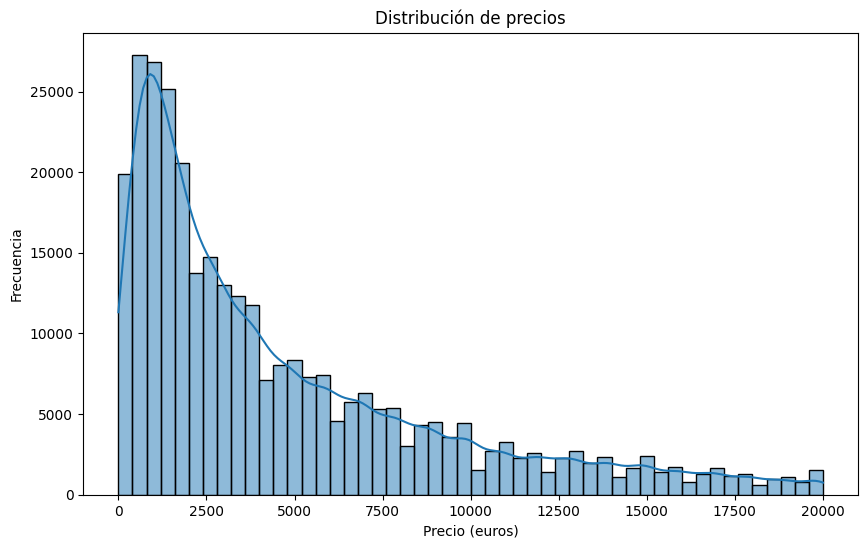

In [5]:
# Revisamos la distribución de precios
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio (euros)")
plt.ylabel("Frecuencia")
plt.show()

Preparamos los datos eliminando columnas irrelevantes, llenando valores faltantes, eliminando duplicados y corrigiendo valores inconsistentes. Además, visualizamos la distribución de precios para identificar patrones y posibles outliers. Esto asegura que el dataset sea confiable y listo para el análisis y modelado.

# 2 Entrenamiento del modelo 

In [6]:
# Separar las variables predictoras (X) y el objetivo (y)
X = df.drop('Price', axis=1)  # Todas las columnas excepto 'Price'
y = df['Price']  # La columna objetivo

# Codificar variables categóricas
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verificamos las dimensiones de los conjuntos
print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de validación: {X_valid.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (187994, 13)
Conjunto de validación: (62665, 13)
Conjunto de prueba: (62665, 13)


 2.1 Regresión lineal

In [10]:
# Inicializamos el modelo de regresión lineal
linear_model = LinearRegression()

# Entrenamos el modelo
linear_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de validación
y_pred_linear = linear_model.predict(X_valid)

# Calculamos la métrica RECM
rmse_linear = np.sqrt(mean_squared_error(y_valid, y_pred_linear))
print(f"RECM para la regresión lineal: {rmse_linear:.2f}")

RECM para la regresión lineal: 2961.73


2.2 Árbol de decisión

In [11]:
# Inicializamos el modelo
tree_model = DecisionTreeRegressor(random_state=42)

# Entrenamos el modelo
tree_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de validación
y_pred_tree = tree_model.predict(X_valid)

# Calculamos la métrica RECM
rmse_tree = np.sqrt(mean_squared_error(y_valid, y_pred_tree))
print(f"RECM para el árbol de decisión: {rmse_tree:.2f}")

RECM para el árbol de decisión: 2350.90


2.3 Bosque aleatorio

In [12]:
# Configuración rápida para el bosque aleatorio
forest_model = RandomForestRegressor(
    n_estimators=50,  # Menos árboles para pruebas rápidas
    max_depth=10,     # Profundidad controlada
    random_state=42,
    n_jobs=-1
)

# Entrenamos el modelo
forest_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de validación
y_pred_forest = forest_model.predict(X_valid)

# Calculamos la métrica RECM
rmse_forest = np.sqrt(mean_squared_error(y_valid, y_pred_forest))
print(f"RECM para el bosque aleatorio: {rmse_forest:.2f}")

RECM para el bosque aleatorio: 1958.75


In [18]:
# Configuración del dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_cols, free_raw_data=False)

# Configuración del modelo con ajustes mejorados
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 10,  # Profundidad máxima
    'num_leaves': 31, # Relación correcta entre max_depth y num_leaves
    'feature_pre_filter': False
}

# Usar callbacks para evitar verbose_eval
callbacks = [lgb.early_stopping(stopping_rounds=10)]

# Entrenamos el modelo
lightgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    callbacks=callbacks
)

# Realizamos predicciones
y_pred_lightgbm = lightgbm_model.predict(X_valid)

# Calculamos la métrica RECM
rmse_lightgbm = np.sqrt(mean_squared_error(y_valid, y_pred_lightgbm))
print(f"RECM para LightGBM: {rmse_lightgbm:.2f}")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 187994, number of used features: 13
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4710.958201
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 1747.32	valid_1's rmse: 1772.5
RECM para LightGBM: 1772.50


# 3 Velocidad y la calidad de los modelos

In [20]:
# Medir tiempo de entrenamiento
start_time = time.time()
linear_model.fit(X_train, y_train)
train_time_linear = time.time() - start_time

# Medir tiempo de predicción
start_time = time.time()
y_pred_linear = linear_model.predict(X_valid)
predict_time_linear = time.time() - start_time

# Calcular RECM
rmse_linear = np.sqrt(mean_squared_error(y_valid, y_pred_linear))
print(f"Regresión Lineal - RECM: {rmse_linear:.2f}, Entrenamiento: {train_time_linear:.2f}s, Predicción: {predict_time_linear:.2f}s")

Regresión Lineal - RECM: 2961.73, Entrenamiento: 0.03s, Predicción: 0.00s


In [21]:
# Medir tiempo de entrenamiento
start_time = time.time()
tree_model.fit(X_train, y_train)
train_time_tree = time.time() - start_time

# Medir tiempo de predicción
start_time = time.time()
y_pred_tree = tree_model.predict(X_valid)
predict_time_tree = time.time() - start_time

# Calcular RECM
rmse_tree = np.sqrt(mean_squared_error(y_valid, y_pred_tree))
print(f"Árbol de Decisión - RECM: {rmse_tree:.2f}, Entrenamiento: {train_time_tree:.2f}s, Predicción: {predict_time_tree:.2f}s")

Árbol de Decisión - RECM: 2350.90, Entrenamiento: 1.46s, Predicción: 0.03s


In [22]:
# Medir tiempo de entrenamiento
start_time = time.time()
forest_model.fit(X_train, y_train)
train_time_forest = time.time() - start_time

# Medir tiempo de predicción
start_time = time.time()
y_pred_forest = forest_model.predict(X_valid)
predict_time_forest = time.time() - start_time

# Calcular RECM
rmse_forest = np.sqrt(mean_squared_error(y_valid, y_pred_forest))
print(f"Bosque Aleatorio - RECM: {rmse_forest:.2f}, Entrenamiento: {train_time_forest:.2f}s, Predicción: {predict_time_forest:.2f}s")

Bosque Aleatorio - RECM: 1958.75, Entrenamiento: 23.38s, Predicción: 0.22s


In [23]:
# Medir tiempo de entrenamiento
start_time = time.time()
lightgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    callbacks=callbacks
)
train_time_lightgbm = time.time() - start_time

# Medir tiempo de predicción
start_time = time.time()
y_pred_lightgbm = lightgbm_model.predict(X_valid)
predict_time_lightgbm = time.time() - start_time

# Calcular RECM
rmse_lightgbm = np.sqrt(mean_squared_error(y_valid, y_pred_lightgbm))
print(f"LightGBM - RECM: {rmse_lightgbm:.2f}, Entrenamiento: {train_time_lightgbm:.2f}s, Predicción: {predict_time_lightgbm:.2f}s")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 187994, number of used features: 13
[LightGBM] [Info] Start training from score 4710.958201


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Did not meet early stopping. Best iteration is:
[100]	training's rmse: 1747.32	valid_1's rmse: 1772.5
LightGBM - RECM: 1772.50, Entrenamiento: 3.25s, Predicción: 0.39s


In [24]:
# Crear una tabla comparativa con pandas
import pandas as pd

results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Árbol de Decisión', 'Bosque Aleatorio', 'LightGBM'],
    'RECM': [rmse_linear, rmse_tree, rmse_forest, rmse_lightgbm],
    'Tiempo de Entrenamiento (s)': [train_time_linear, train_time_tree, train_time_forest, train_time_lightgbm],
    'Tiempo de Predicción (s)': [predict_time_linear, predict_time_tree, predict_time_forest, predict_time_lightgbm]
})

# Mostrar la tabla
print(results)

              Modelo         RECM  Tiempo de Entrenamiento (s)  \
0   Regresión Lineal  2961.726687                     0.030119   
1  Árbol de Decisión  2350.904422                     1.464376   
2   Bosque Aleatorio  1958.751836                    23.379060   
3           LightGBM  1772.498642                     3.247685   

   Tiempo de Predicción (s)  
0                  0.002787  
1                  0.026746  
2                  0.217830  
3                  0.388677  


# Conclusión

Después de evaluar múltiples modelos de predicción para determinar el valor de mercado de coches de segunda mano, se encontró que LightGBM ofrece el mejor balance entre calidad y velocidad y se consideró el más efectivo. Con un RECM de 1772.50, este modelo superó a la Regresión Lineal y el Árbol de Decisión y el Bosque Aleatorio porque fue más preciso. Su tiempo de entrenamiento y predicción es más eficiente que el del Bosque Aleatorio porque fue de 3.25 segundos y 0.39 segundos y el Bosque Aleatorio tuvo un RECM de 1958.75 y necesitó 23.38 segundos para entrenar. La Regresión Lineal y el Árbol de Decisión, aunque rápidos, mostraron una calidad inferior y tuvieron RECM de 2961.73 y 2350.90 respectivamente. Por lo tanto, se recomienda que LightGBM sea utilizado para la app de Rusty Bargain porque permite predicciones precisas y eficientes que cumplen con los objetivos del proyecto.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
    - [x]  Las celdas con el código han sido colocadas en orden de ejecución
    - [x]  Los datos han sido descargados y preparados
    - [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos